In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
from tensorflow_probability.python.distributions.joint_distribution import JointDistributionSequential


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [3]:
#from rwt.wavelets import waveletCoeffs
#from rwt import dwt, idwt, rdwt, irdwt

In [4]:
from skimage import data
from skimage.transform import rescale

/home/alexey/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


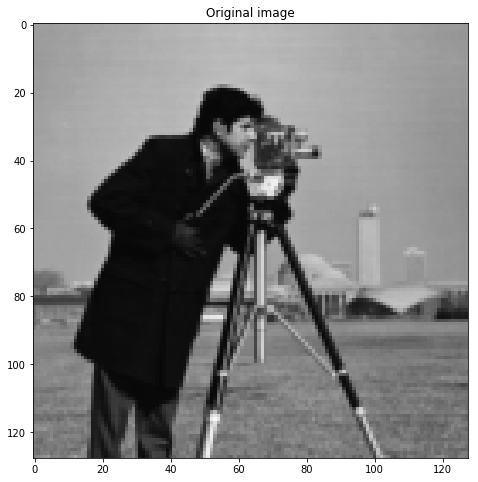

In [5]:
# load image
y0 = data.camera()
y0 = y0.astype(np.float64)

y0 = rescale(y0, 0.25)

M, N = y0.shape

plt.figure(figsize=(8,8))
plt.imshow(y0, cmap=plt.cm.gray, vmin=0, vmax=255)
plt.title('Original image')
plt.show()

In [6]:
from numpy.fft import fft2, ifft2
from scipy.signal import convolve2d

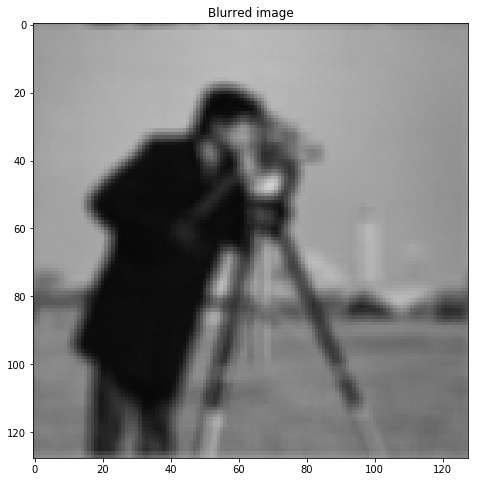

In [7]:
lh = 5

kernel = np.ones((lh, lh))
kernel = kernel/np.sum(kernel)

h = np.zeros(y0.shape)
h[0:lh, 0:lh] = kernel
h = h/h.sum()
h = np.roll(h,-int((lh-1)/2.), axis=1) # circular shift
h = np.roll(h,-int((lh-1)/2.), axis=0) # circular shift

#y = np.real(ifft2(fft2(h)*fft2(y0))) + 0.5*np.random.randn(M,N)
y = convolve2d(y0, kernel, mode='same', boundary='wrap') + 0.5*np.random.randn(M,N)


plt.figure(figsize=(8,8))
plt.imshow(y, cmap=plt.cm.gray, vmin=0, vmax=255)
plt.title('Blurred image')
plt.show()

We use Gaussian priors with variable precision over pixels (ARD prior) to model heavy-tailed distributions of image derivatives - http://library.utia.cas.cz/separaty/2014/ZOI/sroubek-0434275.pdf.

$$\log p(y,x,\lambda) = \log p(y|x)p(x|\lambda)p(\lambda) + const = -\frac{1}{2\sigma^2}\|Hx-y\|^2 + \sum_{i=1}{\left(\frac{1}{2}\log \lambda_i - \frac{\lambda_i}{2}(Dx)^2_i + (a_0-1)\log \lambda_i - b_0 \lambda_i \right)} + const$$

$$\log p(y,x,\lambda) = \log p(y|x)p(x|\lambda)p(\lambda) + const = -\frac{1}{2\sigma^2}\|Hx-y\|^2 + \sum_{i=1}{\left((\alpha_i-1)\log \lambda_i - \beta_i \lambda_i \right)} + const$$

$$\alpha_i = a_0 + \frac{1}{2}$$
$$\beta_i = b_0 + \frac{1}{2}(Dx)^2_i$$

The image prior is defined as follows:

$$z=Dx$$
$$p_x(x)=|D|p_z(Dx)$$

where $D$ is the operator used to compute image derivatives.

In [8]:
def periodic_padding(x, padding):
    '''
    x: shape (d1, d2)
    return x padded with periodic boundaries. i.e. torus or donut
    '''
    d1 = x.shape[0] # dimension 1: height
    d2 = x.shape[1] # dimension 2: width
    p = padding
    # assemble padded x from slices
    #            tl,tc,tr
    # padded_x = ml,mc,mr
    #            bl,bc,br
    top_left = x[-p:, -p:] # top left
    top_center = x[-p:, :] # top center
    top_right = x[-p:, :p] # top right
    middle_left = x[:, -p:] # middle left
    middle_center = x # middle center
    middle_right = x[:, :p] # middle right
    bottom_left = x[:p, -p:] # bottom left
    bottom_center = x[:p, :] # bottom center
    bottom_right = x[:p, :p] # bottom right
    top = tf.concat([top_left, top_center, top_right], axis=1)
    middle = tf.concat([middle_left, middle_center, middle_right], axis=1)
    bottom = tf.concat([bottom_left, bottom_center, bottom_right], axis=1)
    padded_x = tf.concat([top, middle, bottom], axis=0)
    return padded_x

In [9]:
H_FFT = tf.constant(fft2(h))
#HC_FFT = tf.conj(H_FFT)

#H = lambda x: convolve2d(x, kernel, mode='same', boundary='wrap')

H =  lambda x: tf.real(tf.ifft2d(H_FFT*tf.fft2d(tf.cast(x, tf.complex128))))
#HT = lambda x: tf.real(tf.ifft2d(HC_FFT*tf.fft2d(tf.cast(x, tf.complex128))))

"""
def H(x):
    p = lh // 2
    x_padded = periodic_padding(x, padding=p)
    x_cov = tf.squeeze(tf.nn.convolution(tf.reshape(x_padded, [1, p+N+p, p+M+p, 1]), tf.reshape(kernel, [lh, lh, 1, 1]), padding="SAME"))
    return x_cov[p:p+N,p:p+M]
"""

'\ndef H(x):\n    p = lh // 2\n    x_padded = periodic_padding(x, padding=p)\n    x_cov = tf.squeeze(tf.nn.convolution(tf.reshape(x_padded, [1, p+N+p, p+M+p, 1]), tf.reshape(kernel, [lh, lh, 1, 1]), padding="SAME"))\n    return x_cov[p:p+N,p:p+M]\n'

In [10]:
def D(x):
    dx, dy = tf.image.image_gradients(tf.reshape(x, [1, N, M, 1]))
    return tf.reshape(tf.concat([dx, dy], 2), [N, M, 2])

In [11]:
safe_softplus = lambda x: tf.where(tf.greater(x, tf.zeros_like(x)), x + tf.log(1. + tf.exp(-x)), tf.log(1. + tf.exp(x)))

real2pos = lambda x: safe_softplus(x)

In [18]:
a0 = 0.1
b0 = 100
sigma = 1

In [19]:
shape = (N,M,2)

a_var = tf.Variable(1 + np.random.rand(*shape), dtype=tf.float64)
b_var = tf.Variable(1 + np.random.rand(*shape), dtype=tf.float64)
a_posterior = real2pos(a_var)
b_posterior = real2pos(b_var)

mu_posterior = tf.Variable(y, dtype=tf.float64)
sigma_var = tf.Variable(1 + np.random.rand(N,M), dtype=tf.float64)
sigma_posterior = real2pos(sigma_var)


x_posterior = tfd.Normal(mu_posterior, sigma_posterior)
lmbda_posterior = tfd.Gamma(a_posterior, b_posterior)

q_posterior = JointDistributionSequential([x_posterior, lmbda_posterior])

n_samples = 3
q_samples = q_posterior.sample(n_samples)

x_samples = q_samples[0] # shape = (n_samples, ...)
lmbda_samples = q_samples[1]


unnormalized_posterior = 0.

for i in range(n_samples):
    a = a0 + 0.5 - 1
    b = b0 + 0.5*(D(x_samples[i]))**2
    
    log_term = a*tf.reduce_sum(tf.log(lmbda_samples[i]))
    linear_term = tf.reduce_sum(b*lmbda_samples[i])
    lmbda_unnorm_post = log_term - linear_term
    
    residual = H(x_samples[i]) - y
    unnormalized_posterior += -0.5/sigma*tf.reduce_sum(residual**2) + lmbda_unnorm_post


q_entropy = tf.reduce_sum(x_posterior.entropy()) + tf.reduce_sum(lmbda_posterior.entropy()) 

neg_elbo = -(1./n_samples*unnormalized_posterior + q_entropy)


In [20]:
optimizer = tf.train.AdamOptimizer(0.1)
train_vi = optimizer.minimize(neg_elbo)

init = tf.global_variables_initializer()
max_iter = 20000
with tf.Session() as session:
    session.run(init)

    for step in range(max_iter): 
        session.run(train_vi)       
        if step % 1000 == 0:
            objective = session.run(neg_elbo)
            print("Step: %5d, -ELBO: %f" % (step, objective))
          
    y_recovered = session.run(mu_posterior)

Step:     0, -ELBO: 4150857.300253
Step:  1000, -ELBO: 129956.343291
Step:  2000, -ELBO: 99939.164725
Step:  3000, -ELBO: 84778.340546
Step:  4000, -ELBO: 76380.052583
Step:  5000, -ELBO: 70790.104235
Step:  6000, -ELBO: 64852.661952
Step:  7000, -ELBO: 61231.270176
Step:  8000, -ELBO: 58289.549686
Step:  9000, -ELBO: 55967.791710
Step: 10000, -ELBO: 53605.453211
Step: 11000, -ELBO: 51816.515393
Step: 12000, -ELBO: 50910.373355
Step: 13000, -ELBO: 49631.712256
Step: 14000, -ELBO: 49558.906093
Step: 15000, -ELBO: 48962.958739
Step: 16000, -ELBO: 48959.411700
Step: 17000, -ELBO: 48619.233134
Step: 18000, -ELBO: 48435.043052
Step: 19000, -ELBO: 47846.314999


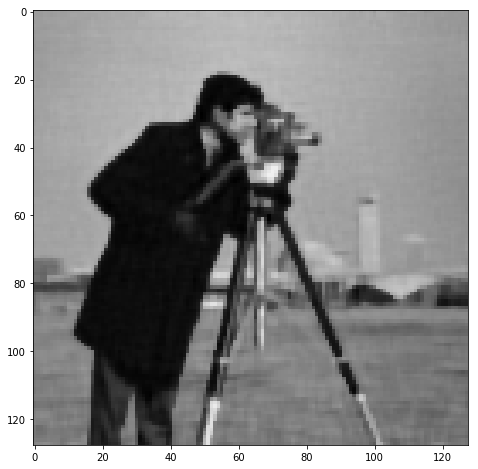

In [21]:
plt.figure(figsize=(8,8))
plt.imshow(y_recovered, cmap=plt.cm.gray, vmin=0, vmax=255)
plt.show()

In [22]:
mse = np.linalg.norm(y_recovered - y0,'fro')**2 /(M*N)

print("MSE: %0.2f" % (mse))

MSE: 33.55
